In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score,train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
uploaded=files.upload()

Saving glass.csv to glass.csv


In [3]:
glass_df = pd.read_csv('glass.csv')
glass_df

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


In [4]:
glass_df.shape

(214, 10)

conclusion

- no of observations = 213
- no of features = 10

In [5]:
glass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [6]:
glass_df["Type"].unique()

array([1, 2, 3, 5, 6, 7])

DATA CLEANING
----

- missing/null values
- duplicates

Missing Values

In [7]:
glass_df.isnull().any()

RI      False
Na      False
Mg      False
Al      False
Si      False
K       False
Ca      False
Ba      False
Fe      False
Type    False
dtype: bool

In [8]:
glass_df.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

conclusion : We have no missing data so all the entries are valid for use.

Duplicated Values

In [9]:
glass_df[glass_df.duplicated()].shape

(1, 10)

In [10]:
glass_df[glass_df.duplicated()]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.0,1


In [11]:
glass_df.drop_duplicates(inplace=True)

STATISTICAL ANALYSIS

In [12]:
glass_df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,1.518348,13.404085,2.679202,1.449484,72.655070,0.498873,8.954085,0.175869,0.057277,2.788732
std,0.003033,0.816662,1.443691,0.495925,0.773998,0.653185,1.425882,0.498245,0.097589,2.105130
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516520,12.900000,2.090000,1.190000,72.280000,0.130000,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.560000,8.600000,0.000000,0.000000,2.000000
75%,1.519150,13.810000,3.600000,1.630000,73.090000,0.610000,9.150000,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


conclusion: The features are not on the same scale , so scaling is reqs

In [13]:
glass_df['Type'].value_counts().sort_index(ascending=True)

1    69
2    76
3    17
5    13
6     9
7    29
Name: Type, dtype: int64



The dataset is unbalanced

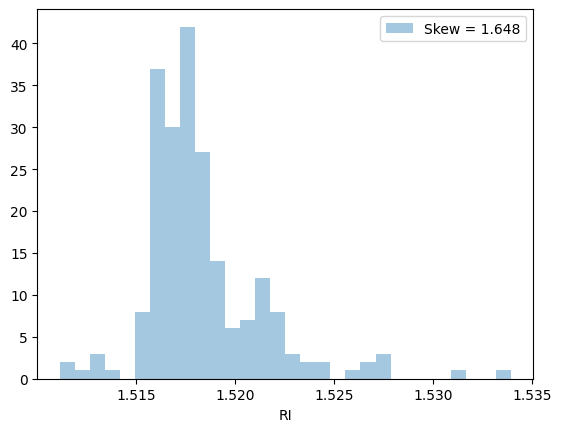

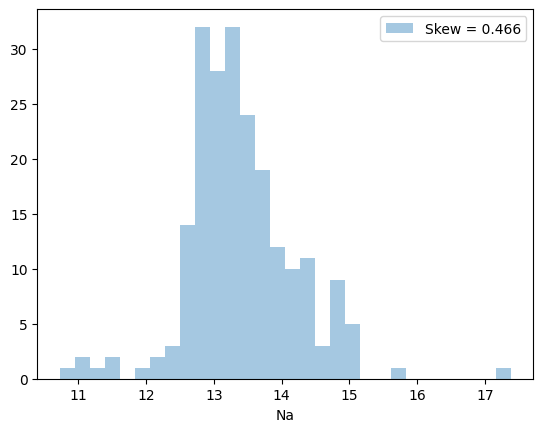

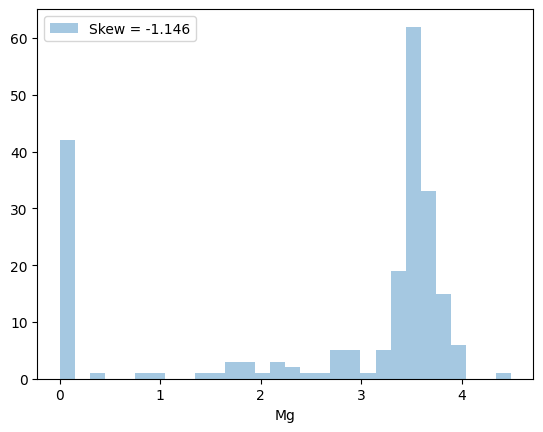

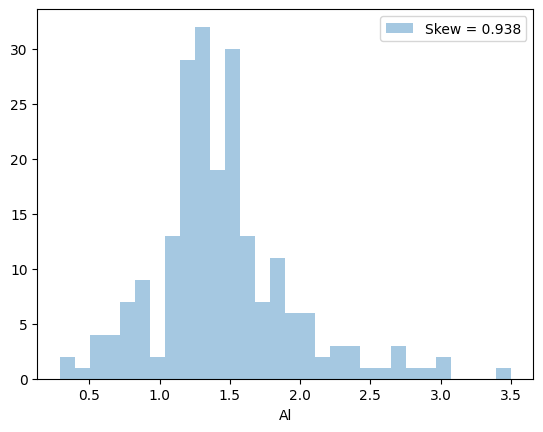

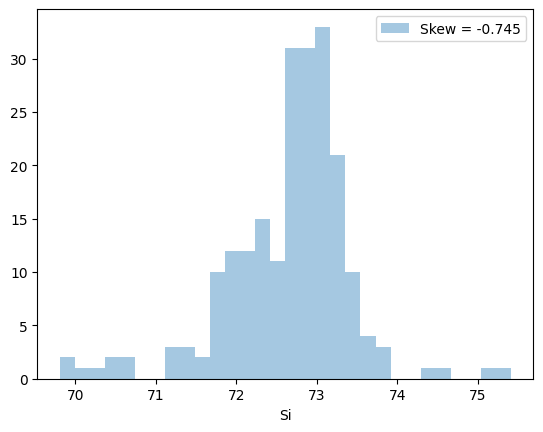

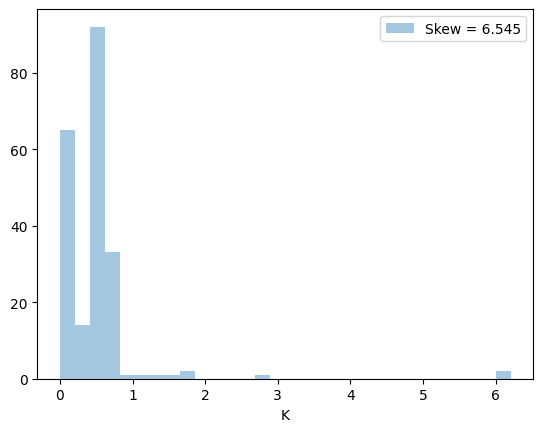

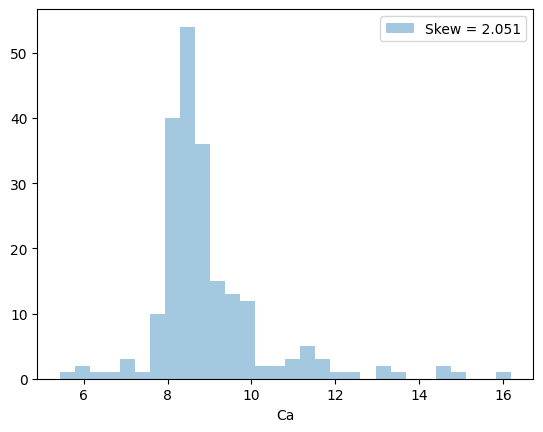

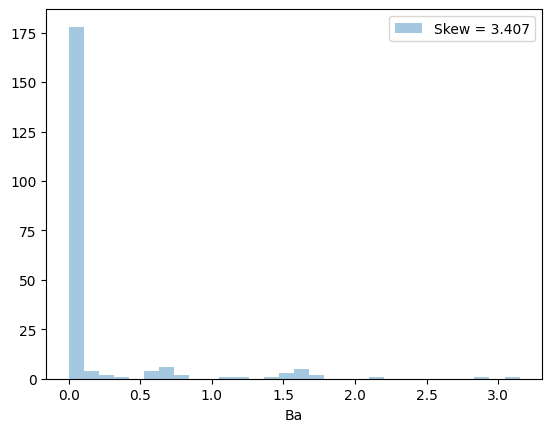

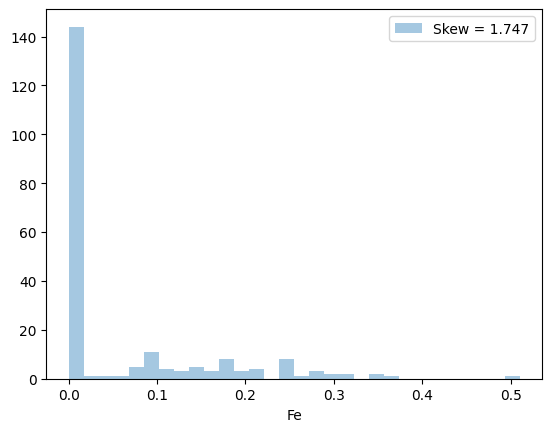

In [14]:
features = glass_df.columns[:-1].tolist()
for feat in features:
    skew = glass_df[feat].skew()
    sns.distplot(glass_df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

None of the features is normally distributed. The features Fe, Ba, Ca and K exhibit the highest skew coefficients. Moreover, the distribution of potassium (K) and Barium (Ba) seem to contain many outliers. Let's identify the indices of the observations containing outliers using Turkey's method.

In [15]:
list(glass_df)

['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']

CORRELATION ANALYSIS
---

<Figure size 800x800 with 0 Axes>

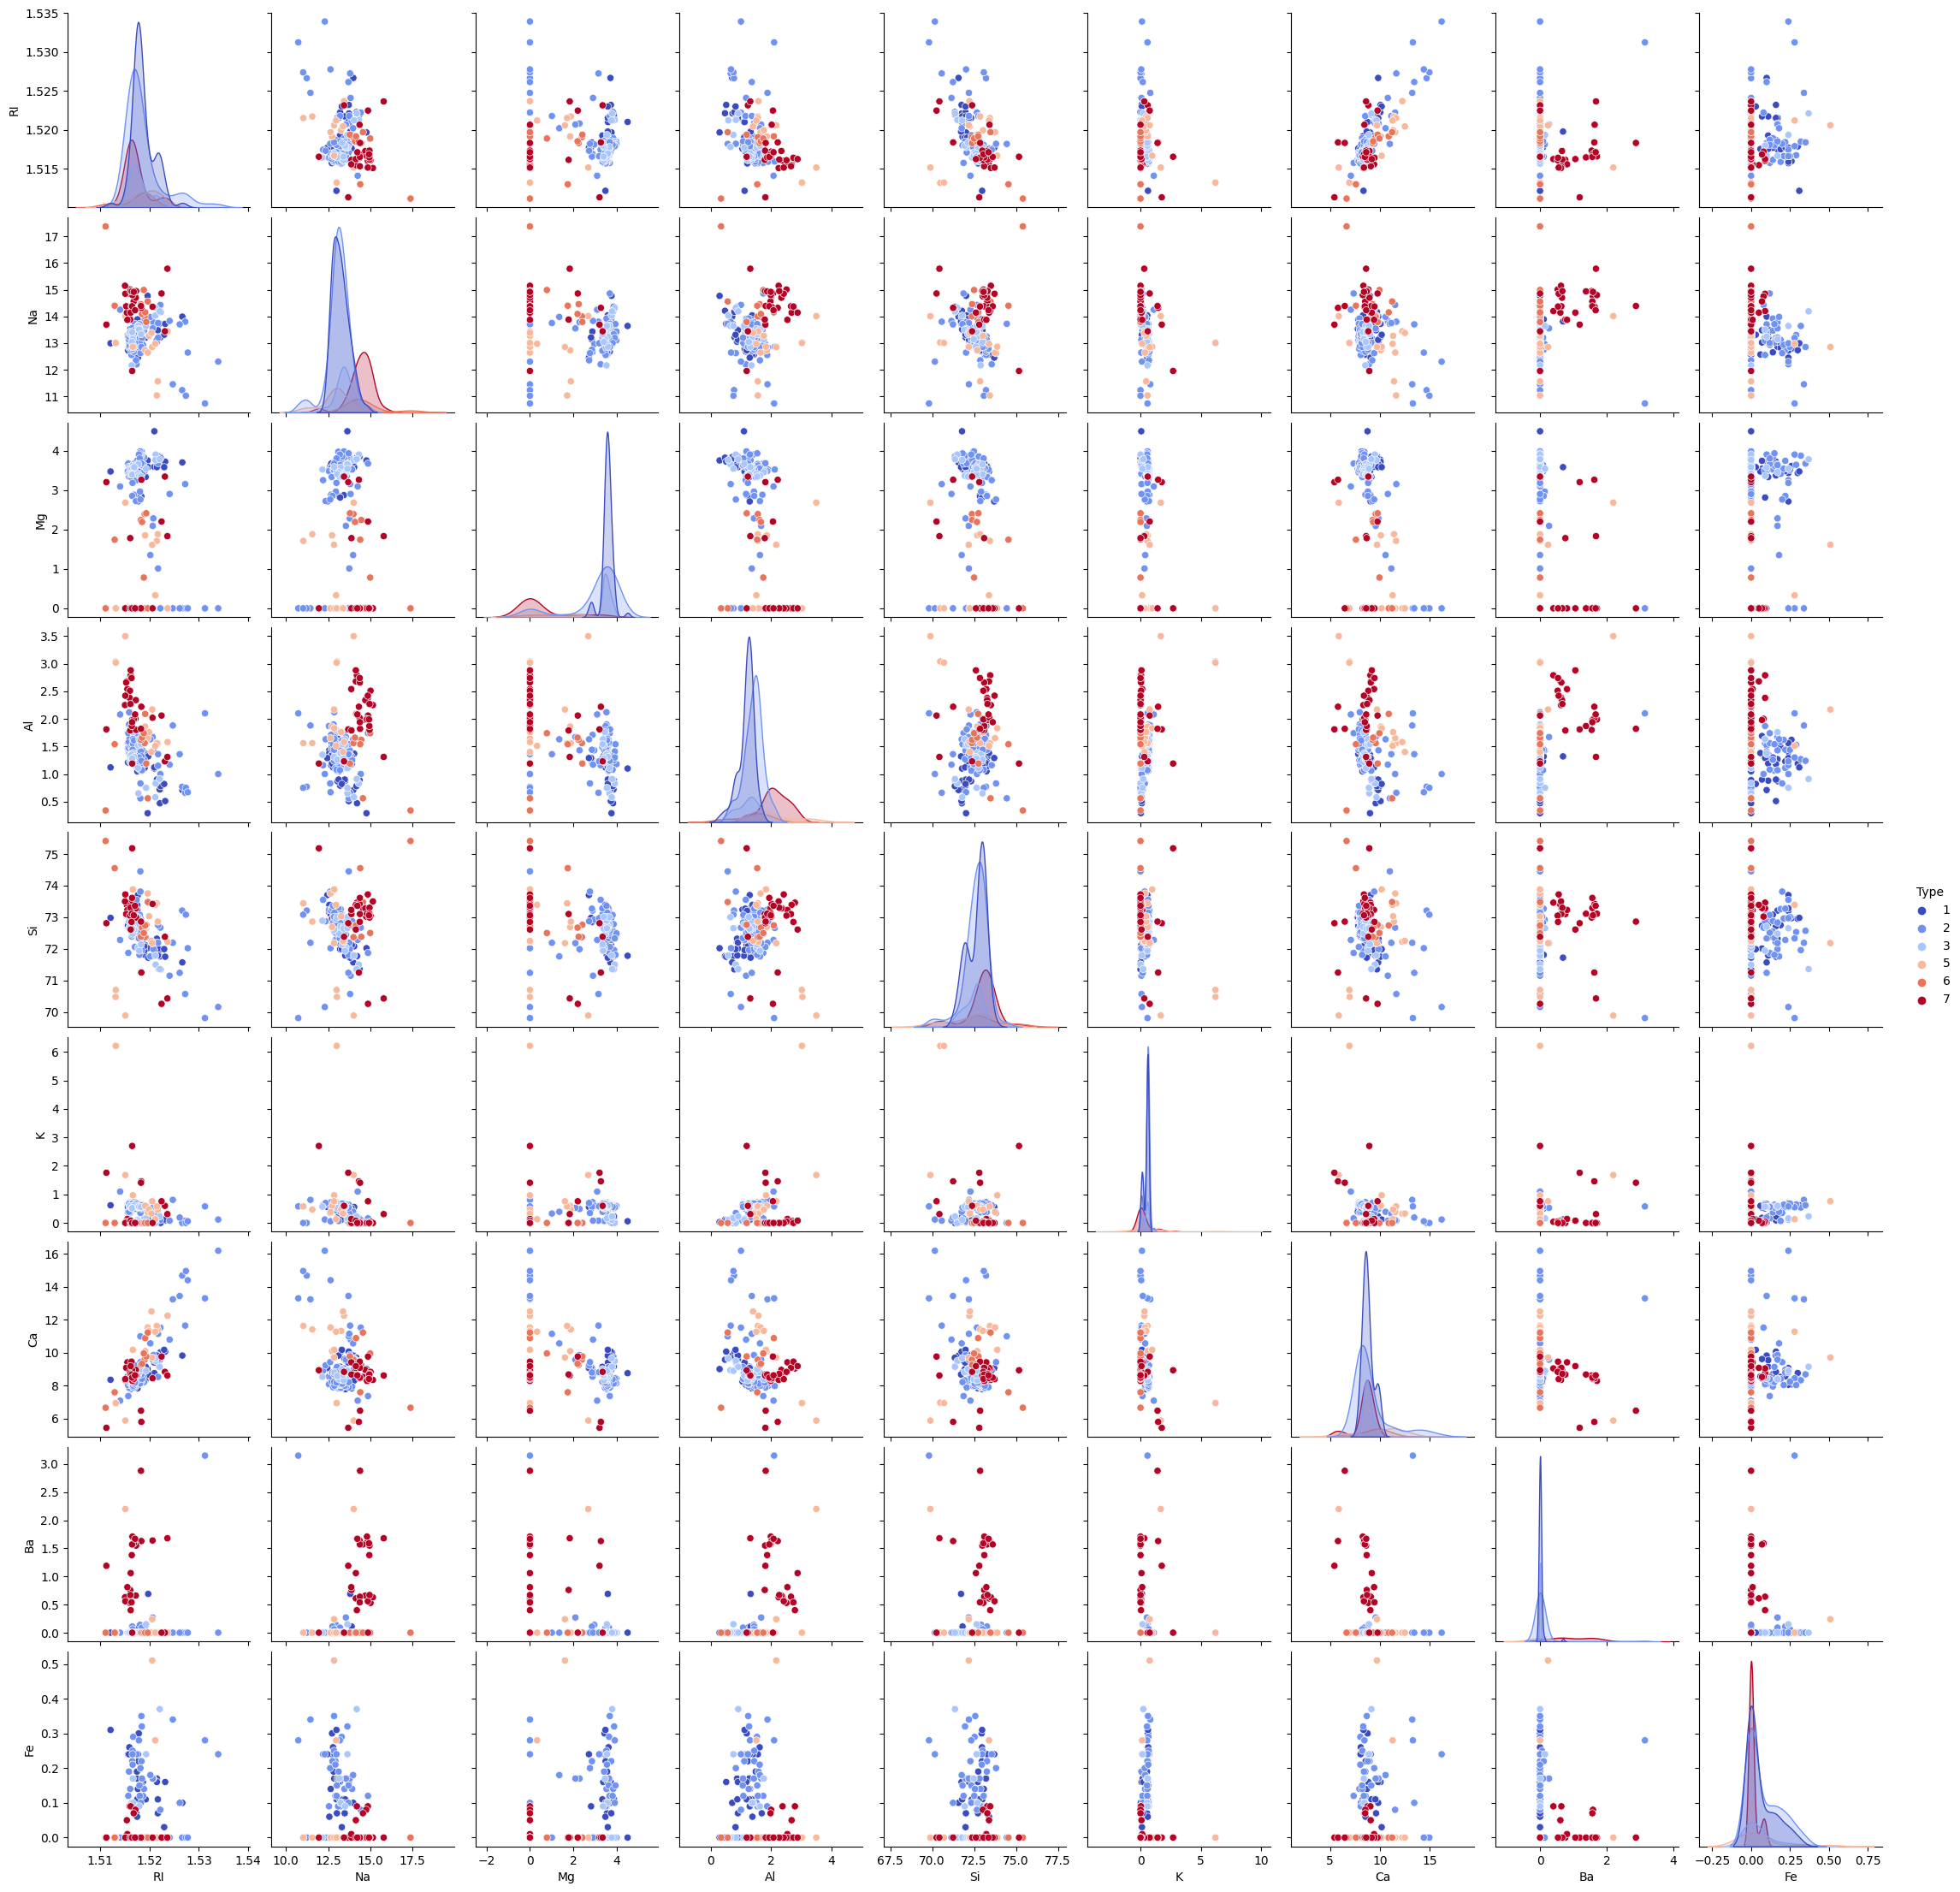

In [16]:
plt.figure(figsize=(8,8))
sns.pairplot(glass_df,hue ='Type', palette='coolwarm')
plt.show()

<Axes: >

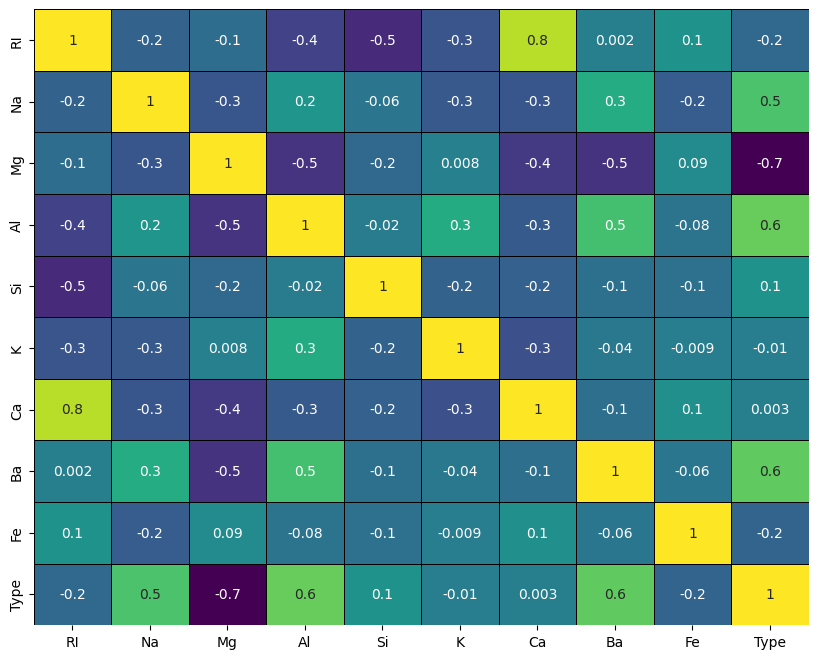

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(glass_df.corr(), annot=True, fmt='.1g', cmap="viridis", cbar=False, linewidths=0.5, linecolor='black')

Text(0.5, 1.0, 'Histogram of Classes')

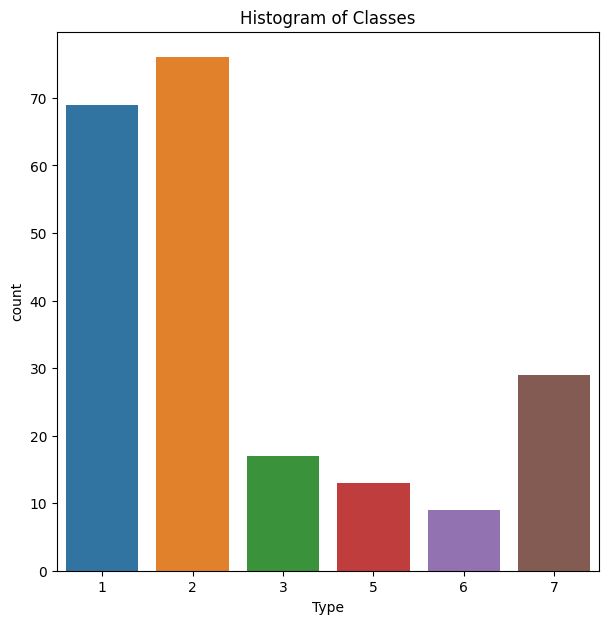

In [18]:
plt.rcParams['figure.figsize'] = (7,7)
sns.countplot(data=glass_df,x='Type')
ax = plt.gca()
ax.set_title("Histogram of Classes")

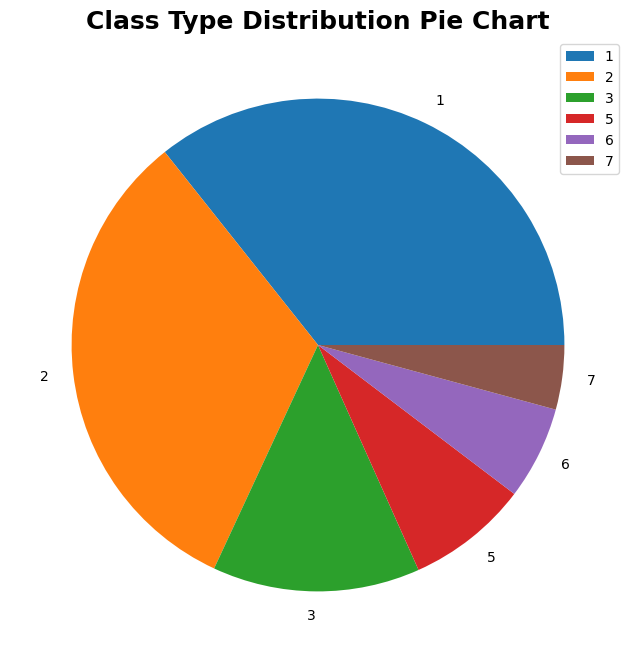

In [19]:
plt.figure(figsize = (12,8))
plt.pie(glass_df['Type'].value_counts(),labels=glass_df.Type.unique())
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

# Data Pre-Processing

In [20]:
glass_df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Skewness analysis
----

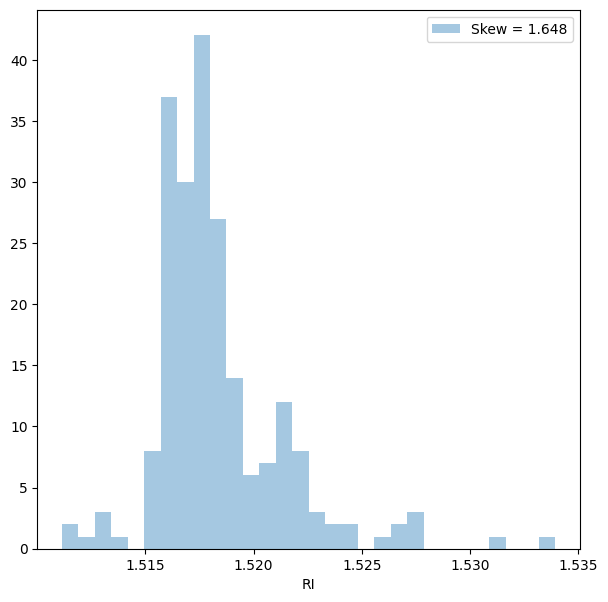

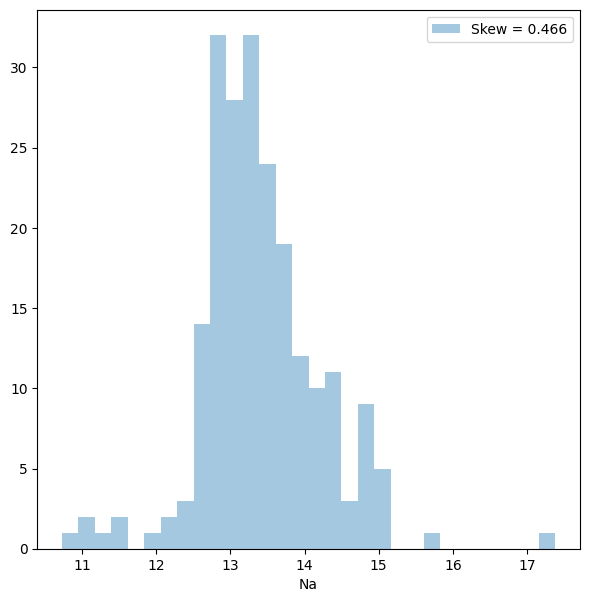

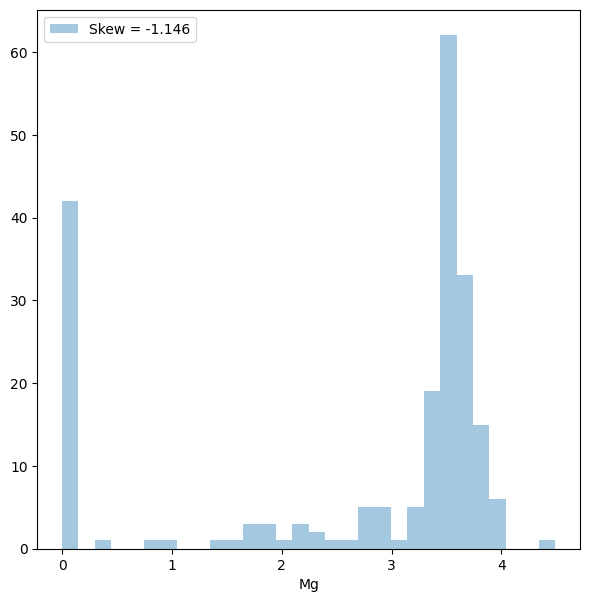

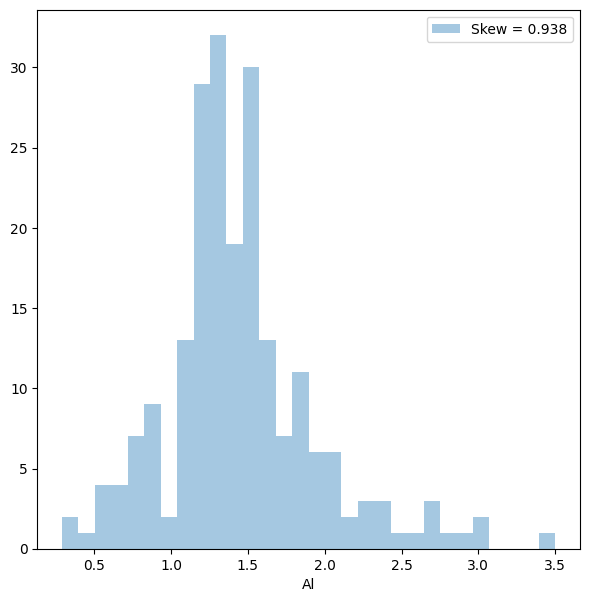

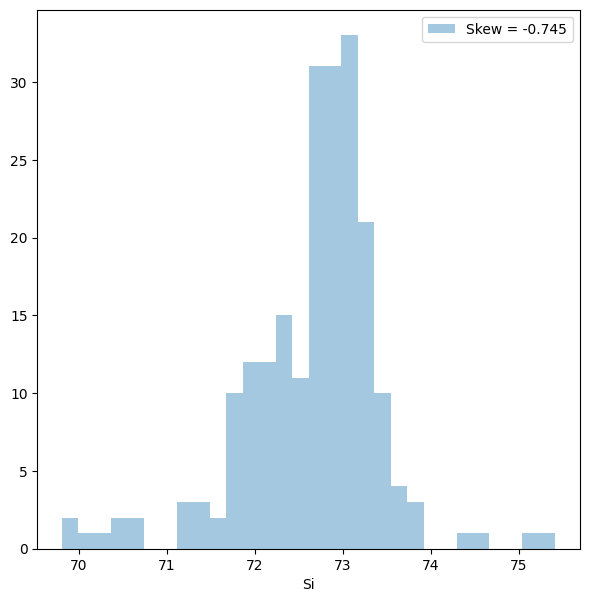

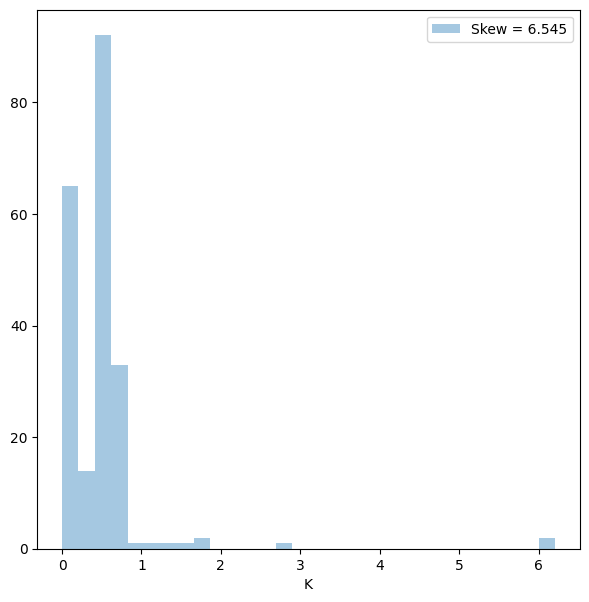

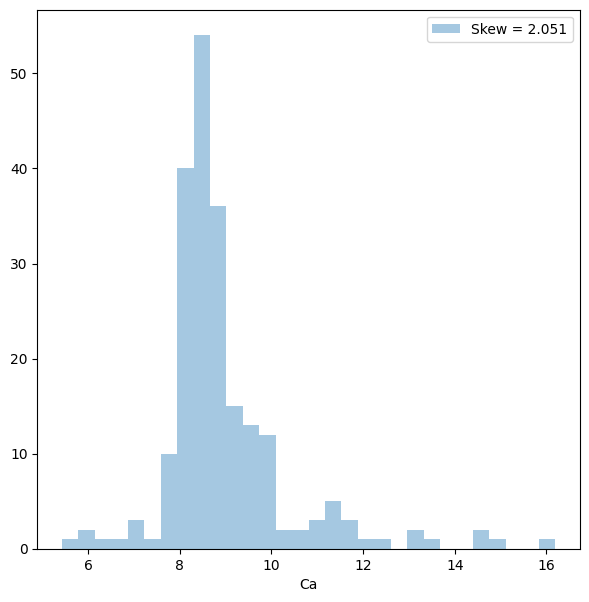

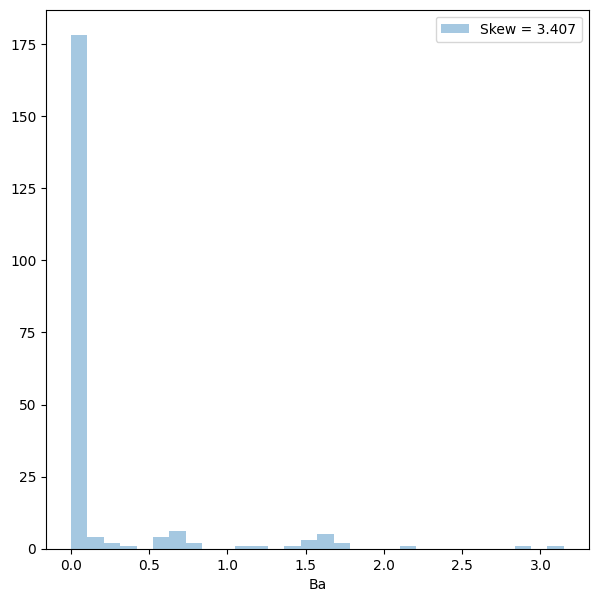

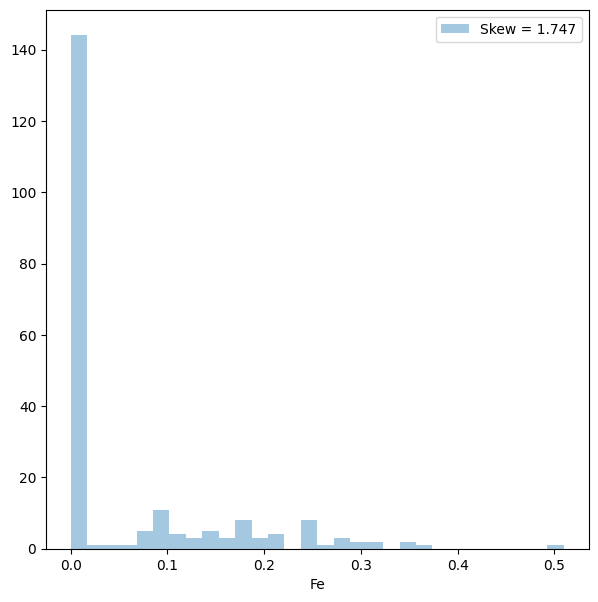

In [21]:
for feat in features:
    skew = glass_df[feat].skew()
    sns.distplot(glass_df[feat], kde=False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

Data transformation

In [22]:
from scipy.stats import boxcox
features_boxcox = []

for feature in features:
    bc_transformed, _ = boxcox(glass_df[feature]+1)
    features_boxcox.append(bc_transformed)

features_boxcox = np.column_stack(features_boxcox)
df_bc = pd.DataFrame(data=features_boxcox, columns=features)
df_bc['Type'] = glass_df['Type']
df_bc.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,2.130000e+02,213.000000,213.000000,213.000000,2.130000e+02,213.000000,213.000000,213.000000,213.000000,212.000000
mean,8.694871e-04,2.029363,9.348202,0.860218,5.502987e+22,0.279370,0.699740,0.019347,0.018832,2.768868
std,2.173512e-19,0.031803,5.398946,0.190628,7.151441e+21,0.172492,0.005438,0.042519,0.027670,2.090006
min,8.694871e-04,1.912076,0.000000,0.253333,3.300987e+22,0.000000,0.674681,0.000000,0.000000,1.000000
25%,8.694871e-04,2.010288,5.085189,0.771586,5.114380e+22,0.115203,0.697213,0.000000,0.000000,1.000000
50%,8.694871e-04,2.026357,12.202361,0.843900,5.587987e+22,0.360678,0.699001,0.000000,0.000000,2.000000
75%,8.694871e-04,2.046071,12.969069,0.948290,5.885134e+22,0.380797,0.701446,0.000000,0.051480,3.000000
max,8.694871e-04,2.164338,19.442595,1.459173,8.724649e+22,0.874960,0.717316,0.119982,0.068376,7.000000


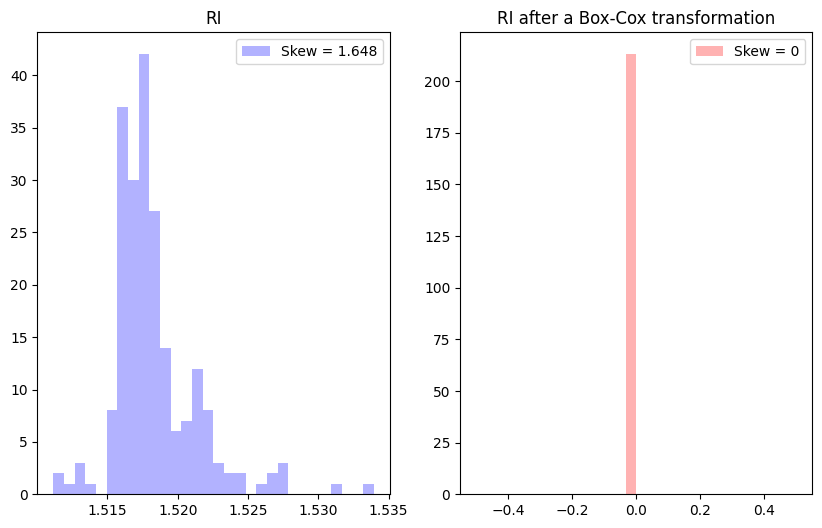

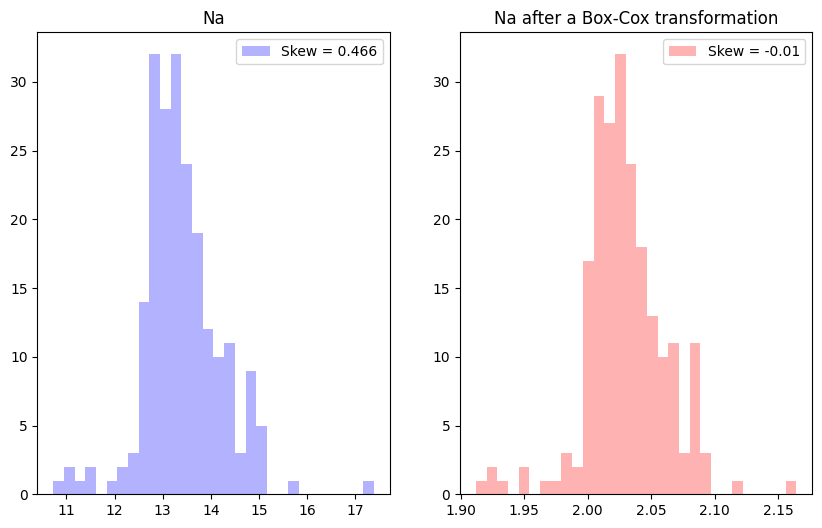

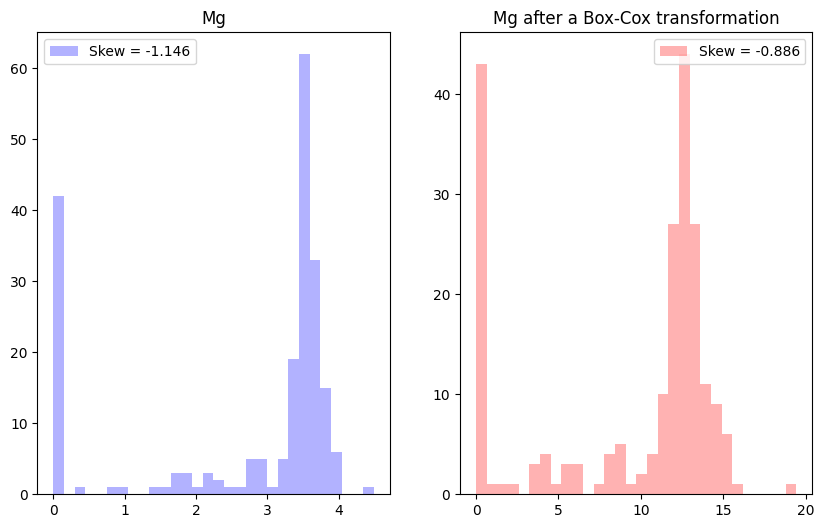

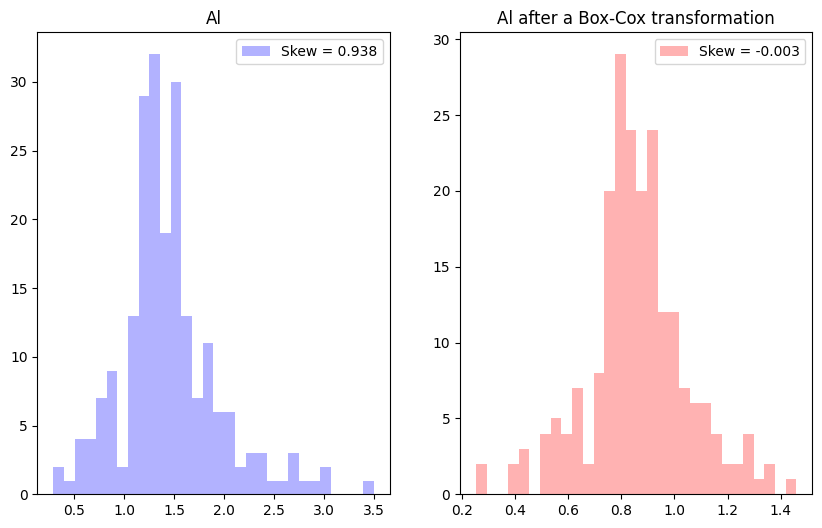

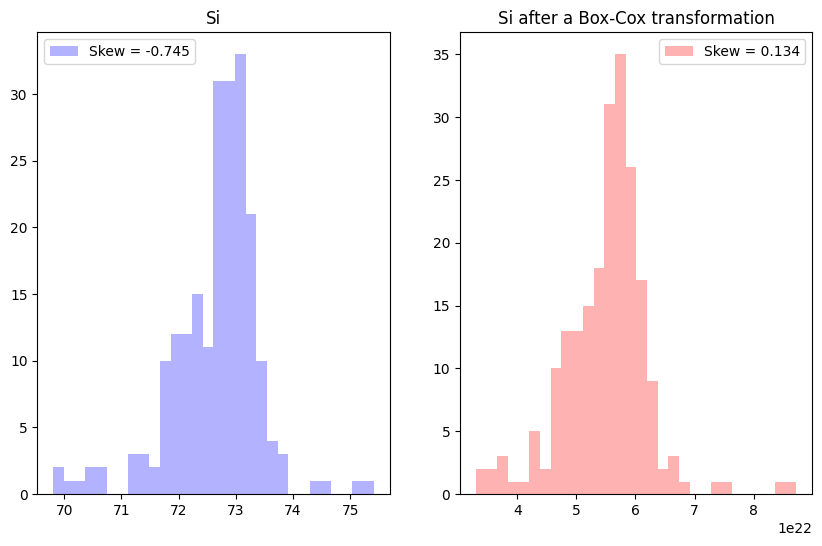

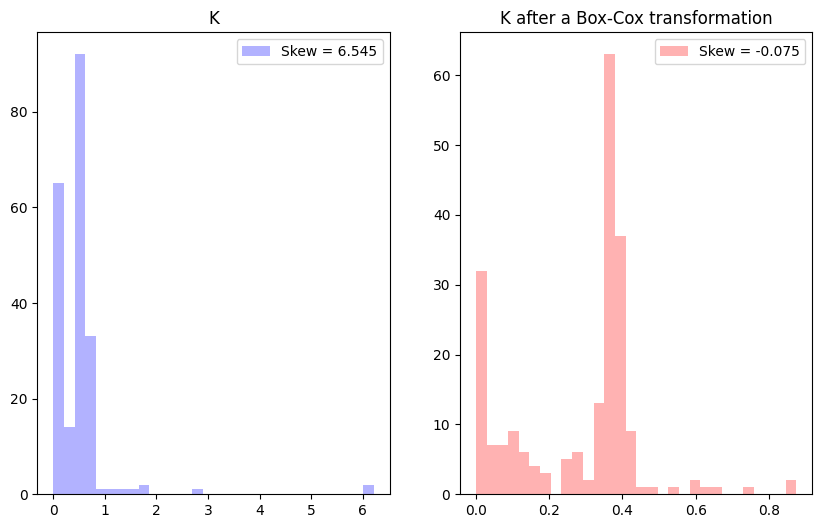

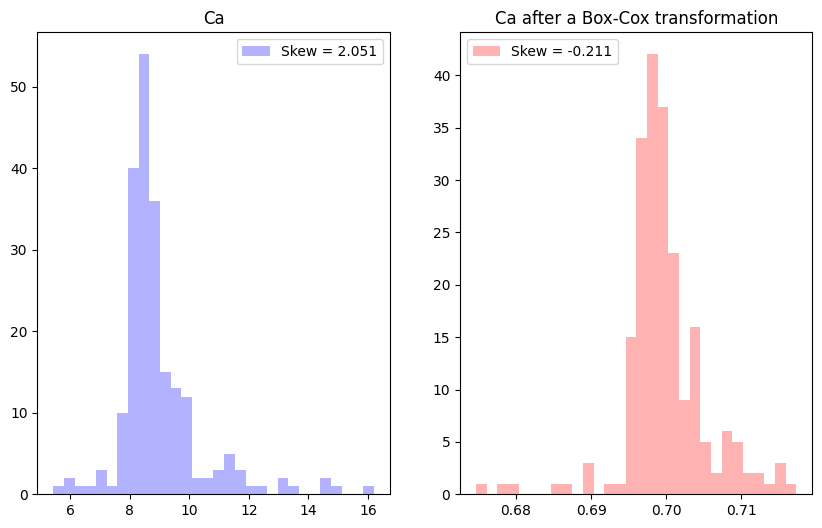

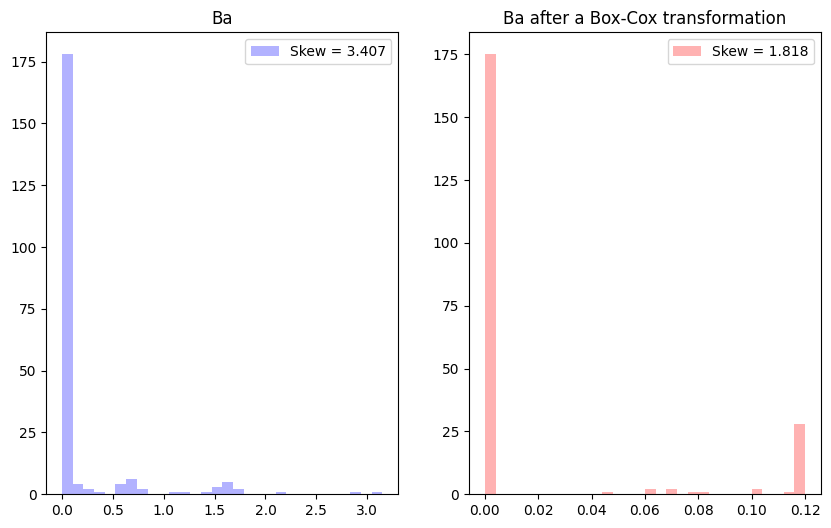

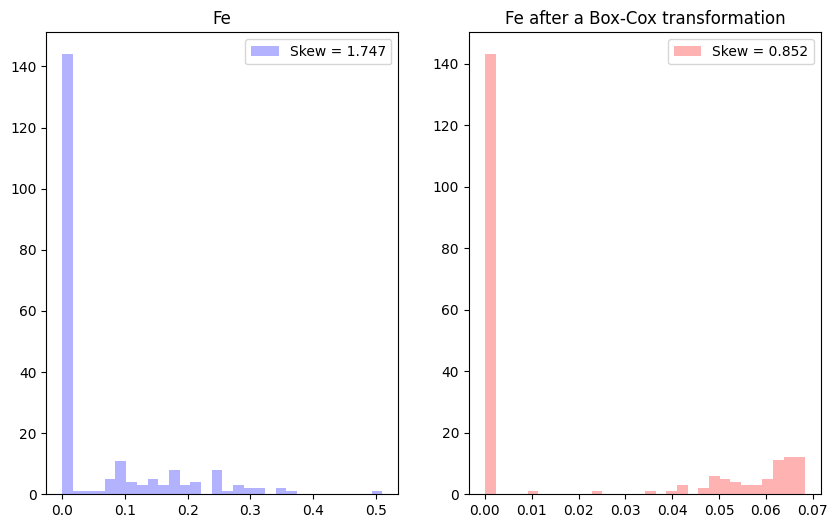

In [23]:
for feature in features:
    fig, ax = plt.subplots(1,2,figsize=(10,6))
    ax[0].hist(glass_df[feature], color='blue', bins=30, alpha=0.3, label='Skew = %s' %(str(round(glass_df[feature].skew(),3))) )
    ax[0].set_title(str(feature))
    ax[0].legend(loc=0)
    ax[1].hist(df_bc[feature], color='red', bins=30, alpha=0.3, label='Skew = %s' %(str(round(df_bc[feature].skew(),3))) )
    ax[1].set_title(str(feature)+' after a Box-Cox transformation')
    ax[1].legend(loc=0)
    plt.show()

conclusion : less skewed after transform

Feature Selection
----

In [24]:
x = glass_df.drop('Type',axis=1)
y = glass_df[['Type']]

In [25]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [26]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (149, 9)
Shape of X_test:  (64, 9)
Shape of y_train:  (149, 1)
Shape of y_test (64, 1)


Standard Scaling
----

as per statistical analysis range between element is very large

In [27]:
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# HYPERPARAMETER TUNING


Grid search for choosing the best Value of K

In [28]:
k_list = np.arange(1, 40, 2)
mean_scores = []
accuracy_list = []
error_rate = []

for i in k_list:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    pred_i = pred_i.reshape(64,1)
    score = cross_val_score(knn,x_train, y_train,cv=10)
    mean_scores.append(np.mean(score))
    error_rate.append(np.mean(pred_i != y_test))

In [29]:
n_neighbors = np.array([2*i+1 for i in range(1,20)])
param_grid = dict(n_neighbors=n_neighbors)
n_neighbors

array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39])

In [30]:
model = KNeighborsClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv =10)
grid.fit(x, y)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39])})

In [31]:
print(grid.best_score_)
print(grid.best_params_)

0.6339826839826839
{'n_neighbors': 3}


 Visualizing the CV results

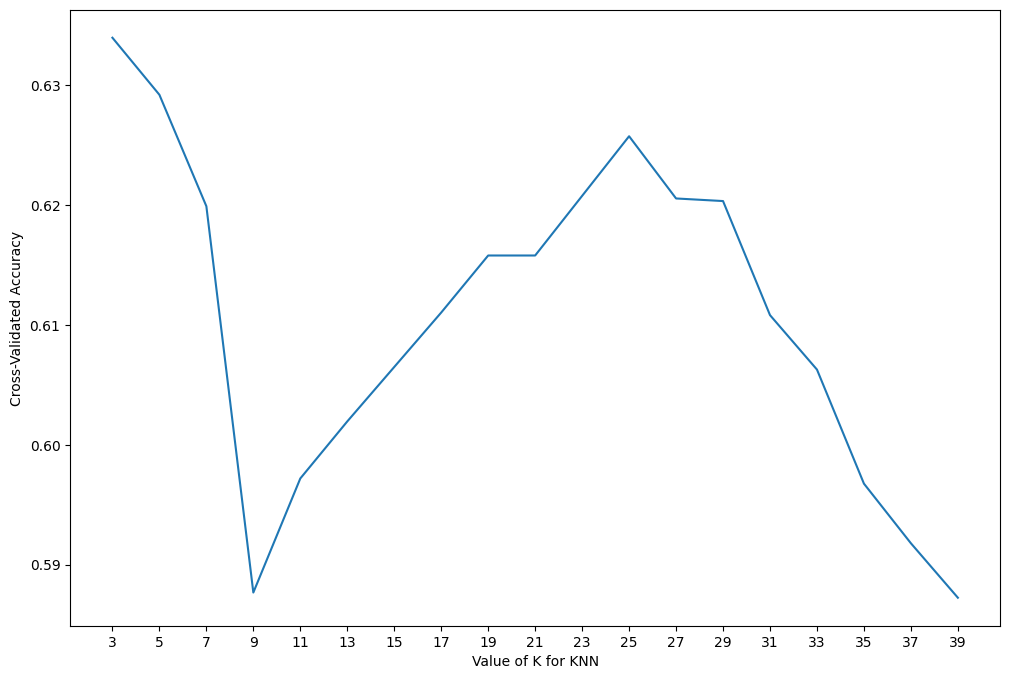

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

k_range = np.array([2*i+1 for i in range(1,20)])
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x, y, cv=10)
    k_scores.append(scores.mean())

plt.figure(figsize=(12,8))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(k_range)
plt.show()

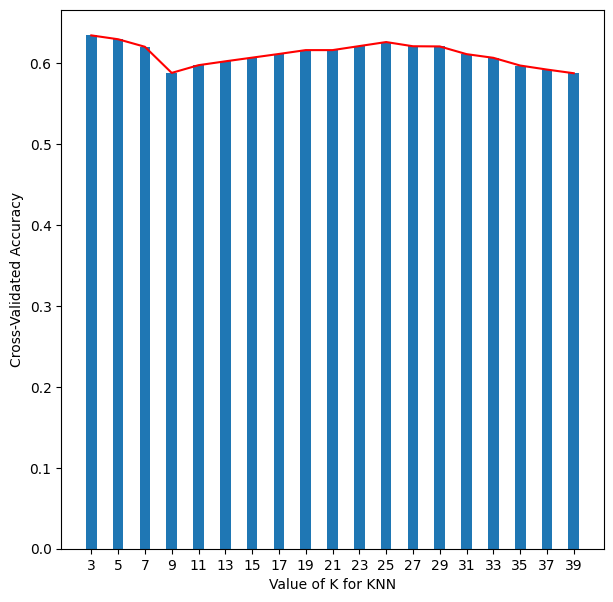

<Figure size 1200x800 with 0 Axes>

In [33]:

k_range = [2*i+1 for i in range(1,20)]
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x, y, cv=10)
    k_scores.append(scores.mean())

plt.bar(k_range, k_scores)
plt.plot(k_range, k_scores, color='red')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(k_range)
plt.figure(figsize=(12,8))
plt.show()

Text(0, 0.5, 'Error Rate')

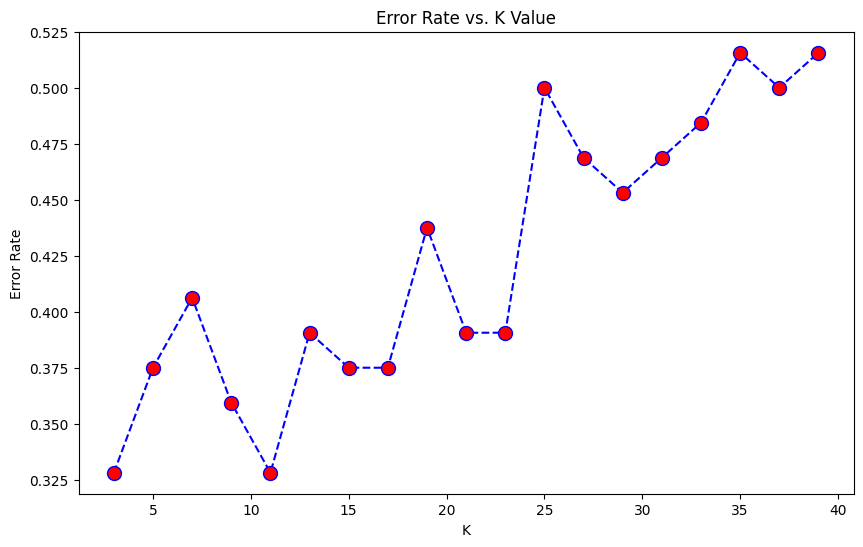

In [34]:
error_rate = []

k_range = [i for i in range(3,40, 2)]
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    pred_i = pred_i.reshape(64,1)
    error_rate.append(np.mean(pred_i != y_test))
plt.figure(figsize=(10,6))
plt.plot([i for i in range(3,40, 2)],error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

Here we can see that that after K>3 the error rate just tends to hover around 0 to 0.5

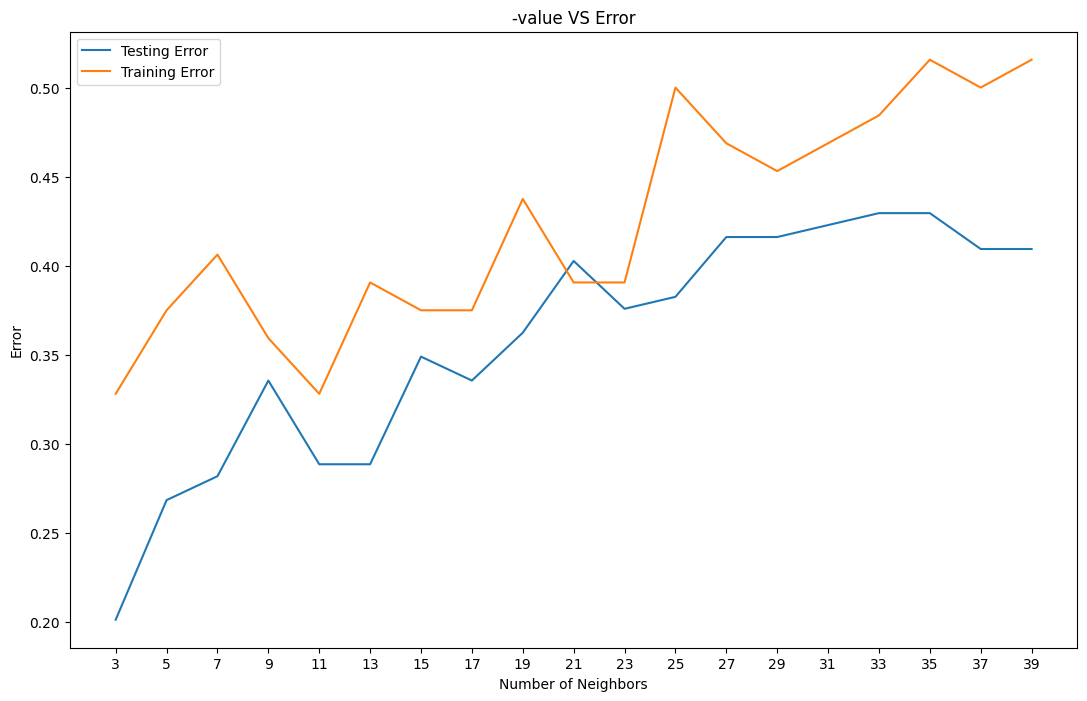

In [35]:
error1= []
error2= []
k_range = [i for i in range(3,40, 2)]
for k in k_range:
    knn= KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    y_pred1= knn.predict(x_train)
    y_pred1 = y_pred1.reshape(149,1)
    error1.append(np.mean(y_train!= y_pred1))
    y_pred2= knn.predict(x_test)
    y_pred2 = y_pred2.reshape(64,1)
    error2.append(np.mean(y_test!= y_pred2))

plt.figure(figsize=[13,8])
plt.plot(k_range, error1, label = 'Testing Error')
plt.plot(k_range, error2, label = 'Training Error')
plt.legend()
plt.title('-value VS Error')
plt.xlabel('Number of Neighbors')
plt.ylabel('Error')
plt.xticks(k_range)
plt.show()

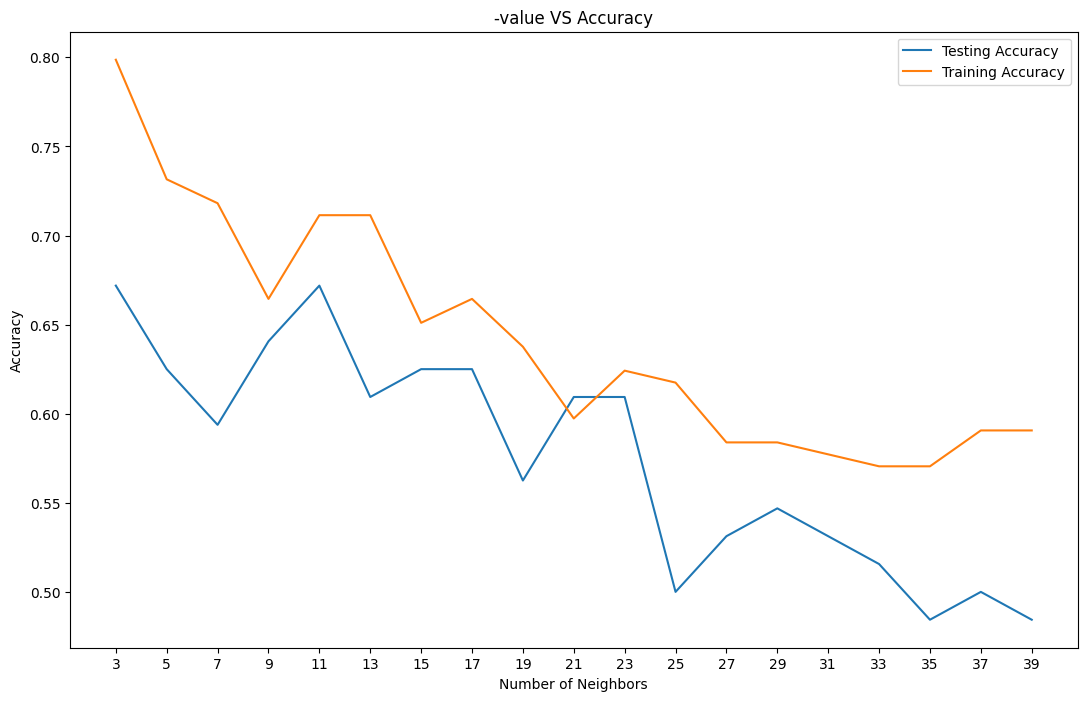

In [36]:
train_accuracy = []
test_accuracy = []

k_range = [i for i in range(3,40, 2)]
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(x_train,y_train)

    train_accuracy.append(knn.score(x_train,y_train))

    test_accuracy.append(knn.score(x_test,y_test))

plt.figure(figsize=[13,8])
plt.plot(k_range, test_accuracy, label = 'Testing Accuracy')
plt.plot(k_range, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('-value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.show()

 MODEL TRAINING

In [37]:

knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

knn.fit(x_train,y_train)


KNeighborsClassifier(n_jobs=1, n_neighbors=3)

In [38]:

pred = knn.predict(x_test)
pred

array([7, 1, 2, 5, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 7, 2, 2, 1, 2, 7, 7,
       7, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 7, 2, 1, 2, 1,
       1, 2, 1, 2, 2, 2, 1, 6, 7, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 5])

MODEL EVALUATION

In [39]:
cm = confusion_matrix(y_test,pred)
cm

array([[17,  3,  0,  0,  0,  0],
       [ 4, 19,  0,  1,  1,  0],
       [ 5,  3,  0,  0,  0,  0],
       [ 0,  1,  0,  1,  0,  0],
       [ 1,  0,  0,  0,  0,  1],
       [ 1,  0,  0,  0,  0,  6]])

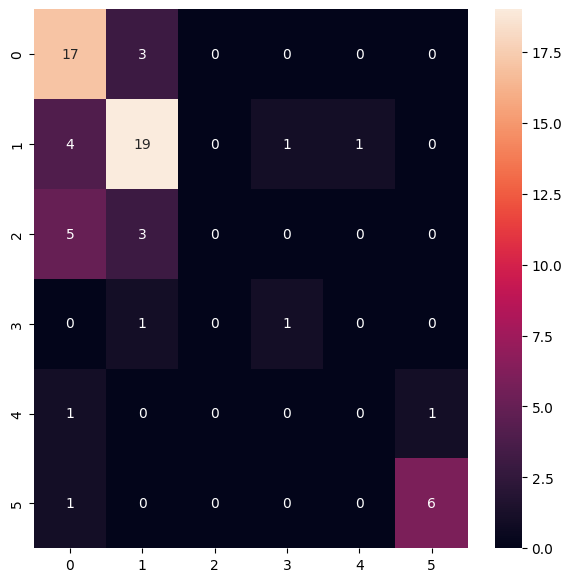

In [40]:

sns.heatmap(cm, annot=True,  fmt='.0f')
plt.show()

**Classification Report**

In [41]:

print('WITH K=3')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=3


[[17  3  0  0  0  0]
 [ 4 19  0  1  1  0]
 [ 5  3  0  0  0  0]
 [ 0  1  0  1  0  0]
 [ 1  0  0  0  0  1]
 [ 1  0  0  0  0  6]]


              precision    recall  f1-score   support

           1       0.61      0.85      0.71        20
           2       0.73      0.76      0.75        25
           3       0.00      0.00      0.00         8
           5       0.50      0.50      0.50         2
           6       0.00      0.00      0.00         2
           7       0.86      0.86      0.86         7

    accuracy                           0.67        64
   macro avg       0.45      0.49      0.47        64
weighted avg       0.58      0.67      0.62        64



 **Data is visualized and found out that scaling was required.
 Optimal no of k found using grid search cv is K=3.
 knn model was preapred.
 Finally model is evaluated by using CONFUSION MATRIX and CLASSIFICATION REPORT**